In [1]:
%load_ext autoreload
%autoreload 2

In [85]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from tqdm import tqdm, tqdm_notebook, trange

sys.path.append('../src/')
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import data_utils as du 
import gee_utils as gu

import torch
from geoclip import GeoCLIP, LocationEncoder, ImageEncoder
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, CLIPTextModel
from PIL import Image

In [3]:
dir_tes_im = '/Users/tplas/repos/PECL/tests/data_test/images_tests/'
ind = 0 
fp_im = os.path.join(dir_tes_im, f'sent2-4band_UKBMS_loc-{str(ind).zfill(4)}_y-2019_m-06-09.tif')
df_bioclim_lc = pd.read_csv('../outputs/s2bms_bioclim_lc_data.csv')
df_s2bms_presence = du.load_s2bms_presence()

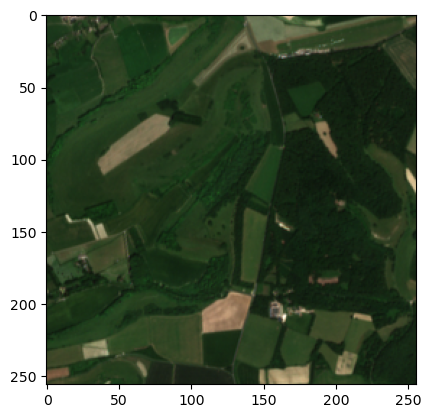

In [14]:
im_rgb = du.load_tiff(fp_im, 'np')[:3, ...]
im_rgb = np.transpose(im_rgb, (1, 2, 0))
im_rgb = np.clip(im_rgb / 3000.0, 0, 1)
plt.imshow(im_rgb)

In [14]:
gps_encoder = LocationEncoder()
gps_data = torch.Tensor([[df_s2bms_presence.lat.iloc[ii], df_s2bms_presence.lon.iloc[ii]] for ii in range(len(df_s2bms_presence))])  # NYC and LA in lat, lon
gps_embeddings = gps_encoder(gps_data)
print(gps_embeddings.shape) 

torch.Size([1329, 512])


In [15]:

_model = CLIPModel.from_pretrained('openai/clip-vit-large-patch14')
_processor = CLIPProcessor.from_pretrained('openai/clip-vit-large-patch14')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [16]:
inputs = _processor(images=Image.fromarray((im_rgb * 255).astype(np.uint8)), return_tensors="pt", padding=True)

In [25]:
with torch.no_grad():
    vision_outputs = _model.vision_model(**inputs)
    image_embeds = vision_outputs[1]
    image_embeds = _model.visual_projection(image_embeds)
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True) 
print(image_embeds.shape)

tensor([ 0.0664,  0.0552, -0.0076, -0.0494,  0.0030,  0.0347,  0.0104,  0.0211,
         0.0169, -0.0255])


In [39]:
caption = du.create_simple_caption(df_bioclim_lc.iloc[ind], include_bioclim=False)
caption

'Location with pastures (46%), non-irrigated arable land (34%) and mixed forest (19%).'

In [40]:
## get text embeddings
text_inputs = _processor(text=[caption], return_tensors="pt", padding=True)
with torch.no_grad():
    text_outputs = _model.text_model(**text_inputs)
    text_embeds = text_outputs[1]
    text_embeds = _model.text_projection(text_embeds)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
print(text_embeds[0, :10])

tensor([ 0.0038,  0.0840, -0.0081, -0.0351, -0.0129, -0.0027,  0.0092, -0.0117,
         0.0014,  0.0027])


In [53]:
model = GeoCLIP()
model.image_encoder.mlp(text_embeds).shape

torch.Size([1, 512])

In [56]:
gps_embeddings.shape

torch.Size([1329, 512])

In [44]:
cosine_sim = torch.matmul(image_embeds, text_embeds.T)
cosine_sim

tensor([[0.2351]])

In [80]:
max_sim= 0
dir_tes_im = '/Users/tplas/data/2025-04-11 S2BMS/sentinel2_satellite-images/y-2018-2019_m-06-09'
gps_encoder = LocationEncoder()
gps_data = torch.Tensor([[df_s2bms_presence.lat.iloc[ii], df_s2bms_presence.lon.iloc[ii]] for ii in range(len(df_s2bms_presence))])  # NYC and LA in lat, lon
gps_embeddings = gps_encoder(gps_data)
assert gps_embeddings.shape[1] == 512

dict_sim = {x: [] for x in ['im_text', 'im_coord', 'text_coord']}

for ind in trange(100):
    fp_im = os.path.join(dir_tes_im, f'sent2-4band_UKBMS_loc-{str(ind).zfill(4)}_y-2019_m-06-09.tif')
    if not os.path.exists(fp_im):
        continue
    im_rgb = du.load_tiff(fp_im, 'np')[:3, ...]
    im_rgb = np.transpose(im_rgb, (1, 2, 0))
    im_rgb = np.clip(im_rgb / 3000.0, 0, 1)
    im_inputs = _processor(images=Image.fromarray((im_rgb * 255).astype(np.uint8)), return_tensors="pt", padding=True)
    caption = du.create_simple_caption(df_bioclim_lc.iloc[ind], include_bioclim=False)
    text_inputs = _processor(text=[caption], return_tensors="pt", padding=True)

    with torch.no_grad():
        vision_outputs = _model.vision_model(**im_inputs)
        image_embeds = vision_outputs[1]
        image_embeds = _model.visual_projection(image_embeds)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        image_embeds_proj = model.image_encoder.mlp(image_embeds)

        text_outputs = _model.text_model(**text_inputs)
        text_embeds = text_outputs[1]
        text_embeds = _model.text_projection(text_embeds)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        text_embeds_proj = model.image_encoder.mlp(text_embeds)

        dict_sim['im_text'].append(float(torch.squeeze(torch.matmul(image_embeds, text_embeds.T).detach()).numpy()))
        dict_sim['im_coord'].append(float(torch.squeeze(torch.matmul(image_embeds_proj, gps_embeddings[ind, :].T).detach()).numpy()))
        dict_sim['text_coord'].append(float(torch.squeeze(torch.matmul(text_embeds_proj, gps_embeddings[ind, :].T).detach()).numpy()))

df_sim = pd.DataFrame(dict_sim)

100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


<Axes: xlabel='im_text', ylabel='text_coord'>

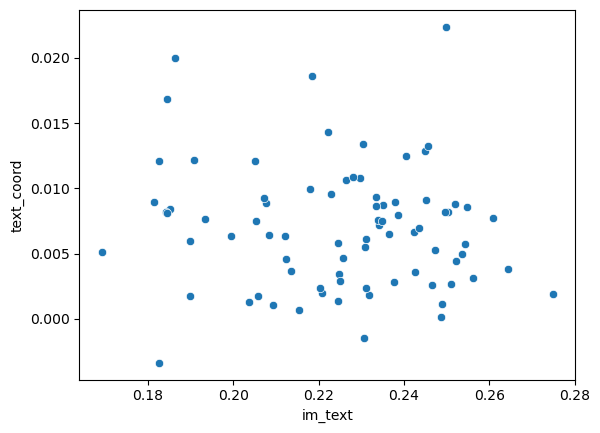

In [95]:
import seaborn as sns
sns.scatterplot(data=df_sim, x='im_text', y='text_coord')